### References:
- [Kaggle dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?datasetId=576013&sortBy=voteCount)
- Some code is borrowed from this [notebook](https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial)

In [2]:
import os
import time
import copy
from random import shuffle

import cv2
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import tqdm.notebook as tqdm

import matplotlib.pyplot as plt

In [3]:
from pathlib import Path


DATA_PATH = Path('./COVID-19_Radiography_Dataset/')
COVID_PATH = Path('COVID-19_Radiography_Dataset/COVID')
NORMAL_PATH = Path('COVID-19_Radiography_Dataset/Normal')

In [5]:
covid_paths = list(COVID_PATH.glob('images/*.png'))
normal_paths = list(NORMAL_PATH.glob('images/*.png'))

val_pct = 0.2
train_paths = []
val_paths = []

with open(DATA_PATH / 'train.csv', 'w') as tr, open(DATA_PATH / 'val.csv', 'w') as val:
    for c, paths in zip(('covid', 'normal'), (covid_paths, normal_paths)):
        num_val = int(len(paths) * val_pct)
        tr.write('\n'.join(c + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[:-num_val]) + '\n')
        val.write('\n'.join(c + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[-num_val:]) + '\n')


{'COVID': 3616, 'Normal': 10192}


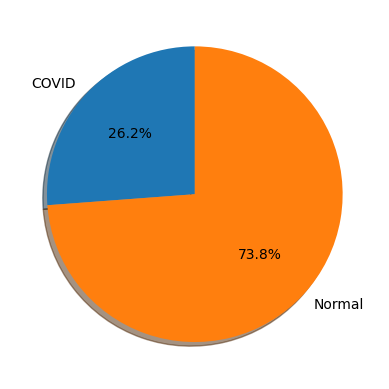

In [6]:
image_count = {}
for c in DATA_PATH.glob('*'):
    if c.is_file():
        continue
    image_count[c.name] = sum(1 for _ in (c / 'images').glob('*'))

    
print(image_count)
#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

I have taken correct propositions of data from each classes while staging my data to avoid overfitted results. Medical Image Datasets will always be like this, we don't have enough data on victim rather we have so many healthy ones. That is what we called is a "Skewed Dataset", obviously we developed methods to approach those problems (like K-Fold Cross Validation) that will explain that in my next notebook.

Lets view some images to know what we are dealing with here. Feel free the run the cell to view images at random from the repository.

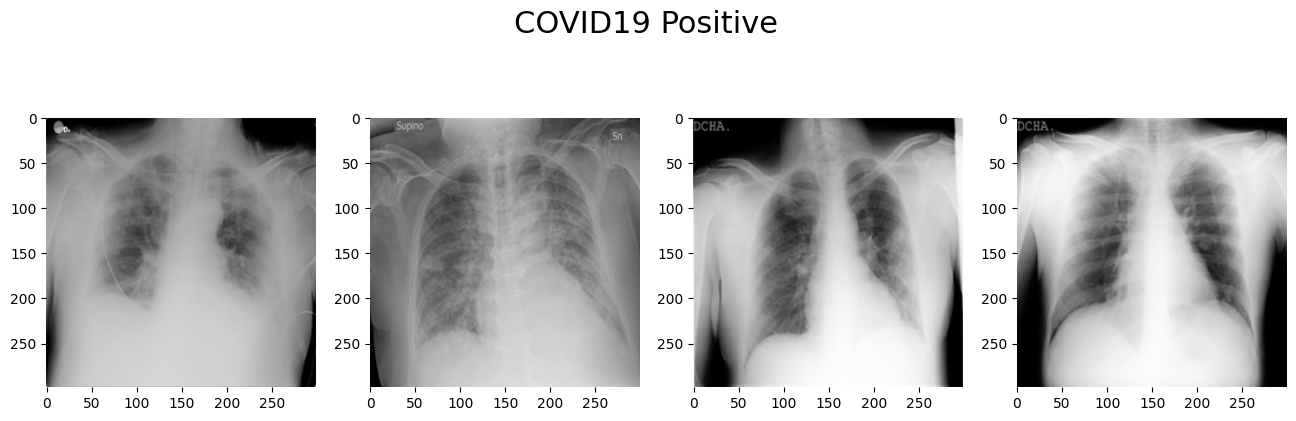

In [7]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i, image in enumerate((COVID_PATH / 'images').glob('*')):
    img = cv2.imread(str(image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
    if i == 3: break

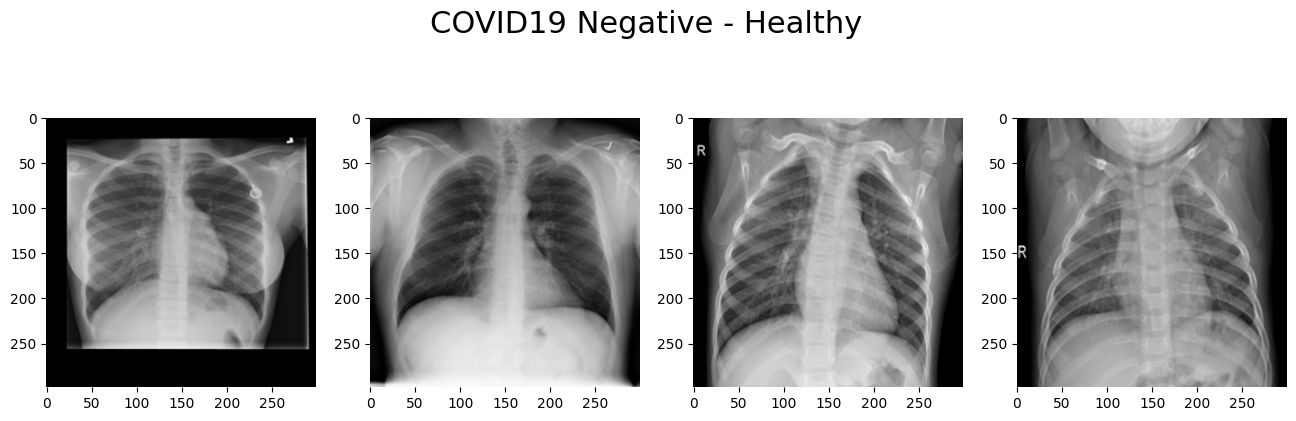

In [8]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i, image in enumerate((NORMAL_PATH / 'images').glob('*')):
    img = cv2.imread(str(image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
    if i == 3: break

Have you seen how similar they look!!. Yeah right, sometimes even for a medical expert. It is hard to diagnose with Xray images. That's why we can help them with our model.

In [9]:
imagenet_mean = 0.485, 0.456, 0.406
imagenet_std = 0.229, 0.224, 0.225
grayscale_coefs = 0.2989, 0.587, 0.114

grayscale_mean = sum(m*c for m, c in zip(imagenet_mean, grayscale_coefs))
grayscale_std = sum(m*c for m, c in zip(imagenet_std, grayscale_coefs))
# grayscale, mean_nums, std_nums
grayscale_mean, grayscale_std


(0.4589225, 0.2255861)

In [10]:
import albumentations as albu


# imagenet norm stats converted to grayscale 
mean = [grayscale_mean]
std = [grayscale_std]

data_transforms = {
    "train": albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.1),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.07, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        albu.Resize(224, 224, cv2.INTER_CUBIC),
        albu.Normalize(mean, std),
    ]),
    "val": albu.Compose([
        albu.Resize(224, 224, cv2.INTER_CUBIC),
        albu.Normalize(mean, std),
    ]),
}

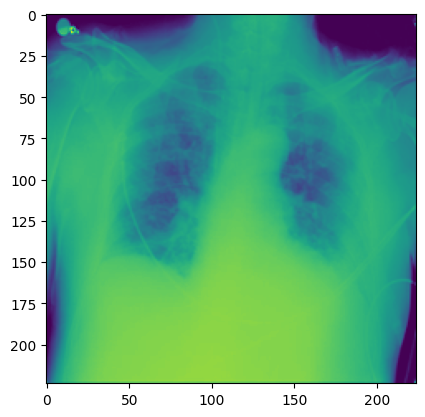

In [11]:
class LungsDataset(torch.utils.data.Dataset):
    CLASSES = 'normal', 'covid'
    def __init__(self, ann_path, transforms=None):
        self.labels, self.image_paths, self.mask_paths = self._load_anns(ann_path)
        self.labels = [self.CLASSES.index(lb) for lb in self.labels]
        self.transforms = transforms
    
    def _load_anns(self, ann_path):
        with open(ann_path) as fid:
            return zip(*(line.rstrip().split(',') for line in fid))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        label, img_path, mask_path = self.labels[index], self.image_paths[index], self.mask_paths[index]
        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        
        sample = {
            'image': img,
            'mask': mask,
        }
        if self.transforms:
            sample = self.transforms(**sample)
        sample['label'] = label
        sample['image'] = sample['image'][np.newaxis]
        sample['mask'] = (sample['mask'] / 255)[np.newaxis]
        return sample

    def get_labels(self):
        # required by https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
        return self.labels
    

train_dst = LungsDataset(DATA_PATH / 'train.csv', data_transforms['train'])
sample = train_dst[0]
plt.imshow(sample['image'][0])
# val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])

In [12]:
from torchsampler import ImbalancedDatasetSampler


def get_dataloaders(batch_size=32, shuffle_test=True):
    train_data = LungsDataset(DATA_PATH / 'train.csv', data_transforms['train'])
    train_sampler = ImbalancedDatasetSampler(train_data)

    test_data = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])
    
    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader


train_loader, test_loader = get_dataloaders()
batch = next(iter(train_loader))

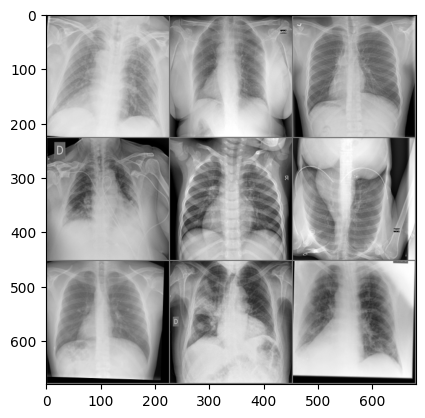

In [13]:
def imshow(inp, size=(30, 30), title=None, ax=None):
    inp = inp * grayscale_std + grayscale_mean
    inp = inp.numpy().transpose((1, 2, 0))
    if ax is None:
        plt.figure(figsize=size)
        plt.imshow(inp, ax=ax)
    ax.imshow(inp)
    if title is not None:
        plt.title(title, size=30)

batch = next(iter(train_loader))
out = torchvision.utils.make_grid(batch['image'][:9], nrow=3)
imshow(out, ax=plt.gca())


In [14]:
# def imshow(inp, size=(30, 30), title=None, ax=None):
#     print(imagenet_std)
#     mean = torch.tensor(imagenet_mean).type_as(inp).reshape(3, 1, 1)
#     std = torch.tensor(imagenet_std).type_as(inp).reshape(3, 1, 1)
#     inp = (inp * std + mean).clamp_(0, 1)
#     inp = inp.numpy().transpose((1, 2, 0))
# #     inp = np.clip(inp, 0, 1)
#     plt.figure(figsize=size)
#     plt.imshow(inp, cmap='gray')
#     if title is not None:
#         plt.title(title, size=30)

# batch = next(iter(train_loader))
# out = torchvision.utils.make_grid(batch['image'][:9], nrow=3)
# imshow(out)

In [15]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=0)

In [16]:
torch.cuda.empty_cache()

In [17]:
def CNN_Model(pretrained=True):
    model = models.resnet18(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
#     in_conv = model.features.conv0
    in_conv = model.conv1
    # reset input layer to accept grayscale images
    model.conv1 = torch.nn.Conv2d(1, in_conv.out_channels, in_conv.kernel_size, in_conv.stride, 
                                  in_conv.padding, in_conv.dilation, in_conv.groups, in_conv.bias, in_conv.padding_mode)
    model.conv1.weight.data.copy_(in_conv.weight.mean(dim=1, keepdims=True))
    if in_conv.bias is not None:
        model.conv1.bias.data.copy_(in_conv.bias )

    # reset the classification layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    return model

Since we haven't froze the CNN layer parameters untrainable, we are going to train a huge number of parameters.

In [18]:
from sklearn.metrics import classification_report


def train_epoch(loader, model, criterion, optimizer, report=False):
    model.train()
    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='train', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
    if report:
        report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
        print(report)
    return current_loss / len(loader)
        

@torch.no_grad()
def validation_epoch(loader, model, criterion):
    model.eval()

    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='val', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)
        # We want variables to hold the loss statistics
        current_loss += loss.item()
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
    
    report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
    print('Validation report:')
    print(report)
    return current_loss / len(loader)


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        train_epoch_loss = train_epoch(dataloaders['train'], model, criterion, optimizer)
        print('Epoch {}. Train Loss: {:.4f}'.format(epoch+1, train_epoch_loss))
        
        val_epoch_loss = validation_epoch(dataloaders['val'], model, criterion)
        print('Epoch {}. Validation Loss: {:.4f}'.format(epoch+1, val_epoch_loss))
        
        scheduler.step()
        print('LR:', optimizer.param_groups[0]['lr'])

        if val_epoch_loss < best_loss:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, val_epoch_loss))
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [19]:
train_labels = train_loader.dataset.labels
num_covid = sum(train_labels)
num_normal = len(train_labels) - num_covid
class_weights = torch.tensor((1 - num_normal / len(train_labels), 1 - num_covid / len(train_labels))).to(device)
class_weights

tensor([0.2619, 0.7381], device='cuda:0')

In [20]:
np.random.seed(777)
torch.manual_seed(777)

dataloaders = {'train': train_loader, 'val': test_loader}

model = CNN_Model(pretrained=True)
criterion = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.5)
print('Number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

base_model = train_model(model, criterion, optimizer, scheduler, num_epochs=8)

Number of trainable parameters: 11171266
Epoch 1/8
----------


C:\Users\Administrator\Desktop\UT\ml-special-course\kaggle2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\Desktop\UT\ml-special-course\kaggle2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 1. Train Loss: 0.1258


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      0.95      0.97      2038
       covid       0.88      0.98      0.93       723

    accuracy                           0.96      2761
   macro avg       0.94      0.97      0.95      2761
weighted avg       0.97      0.96      0.96      2761

Epoch 1. Validation Loss: 0.0782
LR: 0.0001
Val loss Decreased from inf to 0.0782 
Saving Weights... 

Epoch 2/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 2. Train Loss: 0.0594


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      0.98      0.99      2038
       covid       0.94      0.97      0.96       723

    accuracy                           0.98      2761
   macro avg       0.97      0.98      0.97      2761
weighted avg       0.98      0.98      0.98      2761

Epoch 2. Validation Loss: 0.0629
LR: 0.0001
Val loss Decreased from 0.0782 to 0.0629 
Saving Weights... 

Epoch 3/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 3. Train Loss: 0.0473


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      2038
       covid       0.98      0.97      0.98       723

    accuracy                           0.99      2761
   macro avg       0.99      0.98      0.98      2761
weighted avg       0.99      0.99      0.99      2761

Epoch 3. Validation Loss: 0.0524
LR: 5e-05
Val loss Decreased from 0.0629 to 0.0524 
Saving Weights... 

Epoch 4/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 4. Train Loss: 0.0277


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       1.00      0.99      0.99      2038
       covid       0.98      0.99      0.99       723

    accuracy                           0.99      2761
   macro avg       0.99      0.99      0.99      2761
weighted avg       0.99      0.99      0.99      2761

Epoch 4. Validation Loss: 0.0324
LR: 5e-05
Val loss Decreased from 0.0524 to 0.0324 
Saving Weights... 

Epoch 5/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 5. Train Loss: 0.0194


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      1.00      0.99      2038
       covid       0.99      0.97      0.98       723

    accuracy                           0.99      2761
   macro avg       0.99      0.98      0.99      2761
weighted avg       0.99      0.99      0.99      2761

Epoch 5. Validation Loss: 0.0484
LR: 2.5e-05

Epoch 6/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 6. Train Loss: 0.0155


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00      2038
       covid       0.99      0.98      0.99       723

    accuracy                           0.99      2761
   macro avg       0.99      0.99      0.99      2761
weighted avg       0.99      0.99      0.99      2761

Epoch 6. Validation Loss: 0.0279
LR: 2.5e-05
Val loss Decreased from 0.0324 to 0.0279 
Saving Weights... 

Epoch 7/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 7. Train Loss: 0.0101


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00      2038
       covid       0.99      0.98      0.99       723

    accuracy                           0.99      2761
   macro avg       0.99      0.99      0.99      2761
weighted avg       0.99      0.99      0.99      2761

Epoch 7. Validation Loss: 0.0354
LR: 2.5e-05

Epoch 8/8
----------


train:   0%|          | 0/346 [00:00<?, ?it/s]

Epoch 8. Train Loss: 0.0126


val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00      2038
       covid       1.00      0.98      0.99       723

    accuracy                           0.99      2761
   macro avg       0.99      0.99      0.99      2761
weighted avg       0.99      0.99      0.99      2761

Epoch 8. Validation Loss: 0.0425
LR: 2.5e-05

Training complete in 6m 59s
Best val loss: 0.0279


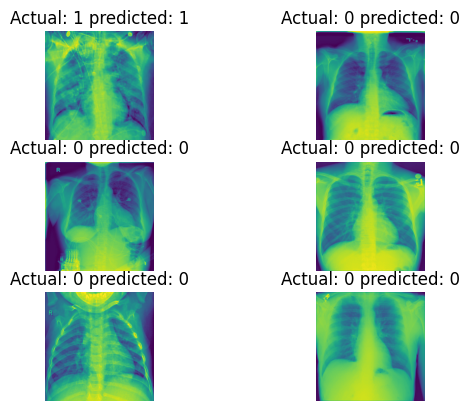

In [26]:
@torch.no_grad()
def visualize_model(model, num_images=6):
    model.eval()
    images_handled = 0
    ax = plt.figure()

    for i, batch in enumerate(dataloaders['val']):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        for j in range(inputs.size()[0]):
            images_handled += 1    
            ax = plt.subplot(num_images//2, 2, images_handled)
            ax.axis('off')
            ax.set_title('Actual: {} predicted: {}'.format(labels[j].item(), preds[j]))
            imshow(inputs.cpu()[j], (5,5), ax=ax)

            if images_handled == num_images:
                return


visualize_model(model)
plt.show()

In [33]:
torch.save(model.state_dict(), 'resnet18_covid_pretrain.pth')
validation_epoch(test_loader, model, criterion)

val:   0%|          | 0/87 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00      2038
       covid       0.99      0.98      0.99       723

    accuracy                           0.99      2761
   macro avg       0.99      0.99      0.99      2761
weighted avg       0.99      0.99      0.99      2761



0.028054312127791824